In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

In [13]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

In [14]:
infected_folder = 'Infected'
infected_images = load_images_from_folder(infected_folder)
n_infected_folder = 'Not_Infected'
n_intected_images = load_images_from_folder(n_infected_folder)

In [15]:
itr = round(501*0.5)
ival = round(550*0.1)
ite = round(501*0.4)

ntr = round(550*0.5)
nval = round(550*0.1)
nte = round(550*0.4)

In [16]:
covid_dir = 'Covid_CT'
os.mkdir(covid_dir)

In [17]:
# train, val, test folder
train_dir = './Covid_CT/train'
val_dir = './Covid_CT/val'
test_dir = './Covid_CT/test'

os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

# infected folder
in_train = './Covid_CT/train/infected'
in_val = './Covid_CT/val/infected'
in_test = './Covid_CT/test/infected'

os.mkdir(in_train)
os.mkdir(in_val)
os.mkdir(in_test)

#not infected folder
not_in_train = './Covid_CT/train/Not_infected'
not_in_val = './Covid_CT/val/Not_infected'
not_in_test = './Covid_CT/test/Not_infected'

os.mkdir(not_in_train)
os.mkdir(not_in_val)
os.mkdir(not_in_test)

In [18]:
def infected_images_to_folder(infected_images, train_dir, val_dir, test_dir):
    for i in range(len(infected_images)):
        img_name = "{}.jpg".format(i)
        if i in range(0, itr+1):
            cv2.imwrite(os.path.join(train_dir, img_name), infected_images[i])
        elif i in range(itr+1, itr+ival+1):
            cv2.imwrite(os.path.join(val_dir, img_name), infected_images[i])
        else:
            cv2.imwrite(os.path.join(test_dir, img_name), infected_images[i])

In [19]:
def not_infected_images_to_folder(n_intected_images, train_dir, val_dir, test_dir):
    for i in range(len(n_intected_images)):
        img_name = "{}.jpg".format(i)
        if i in range(0, ntr+1):
            cv2.imwrite(os.path.join(train_dir, img_name), n_intected_images[i])
        elif i in range(ntr+1, ntr+nval+1):
            cv2.imwrite(os.path.join(val_dir, img_name), n_intected_images[i])
        else:
            cv2.imwrite(os.path.join(test_dir, img_name), n_intected_images[i])

In [20]:
infected_images_to_folder(infected_images, './Covid_CT/train/infected', './Covid_CT/val/infected', './Covid_CT/test/infected')
not_infected_images_to_folder(n_intected_images, './Covid_CT/train/Not_infected', './Covid_CT/val/Not_infected', './Covid_CT/test/Not_infected')

In [48]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

vali_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 30,
    class_mode = 'binary',
    color_mode='grayscale'
)

validation_generator = vali_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 30,
    class_mode = 'binary',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 30,
    class_mode = 'binary',
    color_mode='grayscale'
)

# 2. Dropout 추가 및 Dense Node를 줄인다. & 4. 이미지 픽셀을 더 작게 150*150으로 축소한다.
IMAGE_ROWS = 150
IMAGE_COLS = 150
BATCH_SIZE = 30
IMAGE_SHAPE = (IMAGE_ROWS,IMAGE_COLS,1)



model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SHAPE))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.7))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.7))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), # 'rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=15, epochs=10, validation_data = validation_generator, validation_steps = 1)

Found 527 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 414 images belonging to 2 classes.
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 82944)             0      

In [49]:
tr_score = model2.evaluate_generator(train_generator)
print('Train Loss : {:.4f}'.format(tr_score[0]))
print('Train Accuracy : {:.4f}'.format(tr_score[1]))

te_score = model2.evaluate(test_generator)
print('Test Loss : {:.4f}'.format(te_score[0]))
print('Test Accuracy : {:.4f}'.format(te_score[1]))

Train Loss : 0.2285
Train Accuracy : 0.9526
14/14 [==============================] - 2s 137ms/step - loss: 0.9126 - acc: 0.4106
Test Loss : 0.9126
Test Accuracy : 0.4106


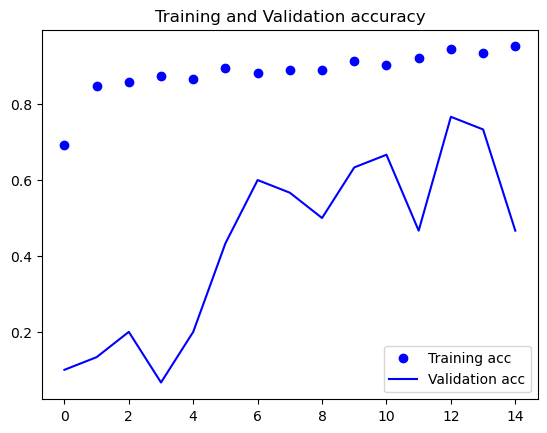

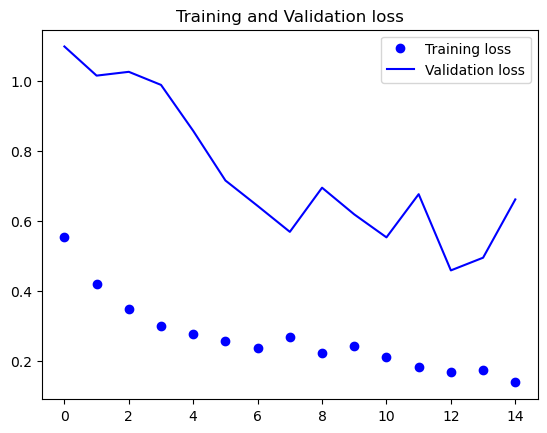

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [50]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

from tensorflow.keras.utils import plot_model

plot_model(model, to_file='CNN1.png', show_shapes=True)

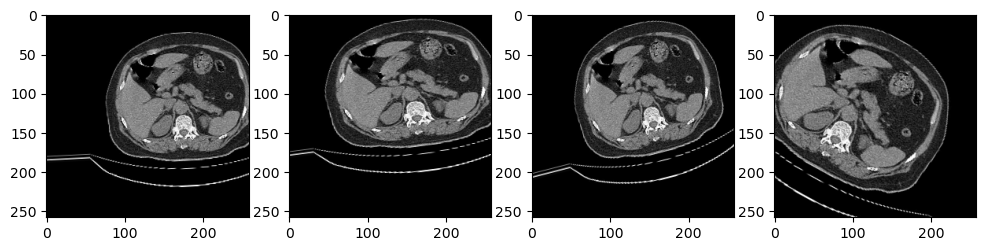

In [38]:
import os
from tensorflow.keras.preprocessing import image

one_fname = r'C:\Users\parks\OneDrive\COVID-19_CT\Covid_CT\train\infected\202.jpg'
img = image.load_img(one_fname, target_size=(258,258))

x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)

i = 0
plt.figure(figsize=(12,6))

for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(1, 4,i+1)
    plt.imshow(image.array_to_img(batch[0]))

    i += 1
    if i % 4 == 0:
        break

plt.show()